# 📝 Text super-resolution
* team name and members: Super-girls, **Agata Żywot 148258, Zuzanna Gawrysiak 148255**
* selected problem and dataset: Super-resolution, [TextZoom](https://paperswithcode.com/dataset/textzoom)

In [1]:
import cv2
import PIL
import numpy as np
from IPython.display import display
import sys
if '../' not in sys.path:
    sys.path.append('../')
import random
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
print("Using torch", torch.__version__)

from src.mdb_to_jpg import mdb_to_jpg
from src.utils import *
from src.data import *
from src.models.srresnet import _NetG, _NetD

Using torch 1.12.1


In [2]:
torch.manual_seed(8)
random.seed(8)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda") 
    
else:
    device = torch.device("cpu")

print(f"Using torch { torch.__version__} on {device}")

Using torch 1.12.1 on cuda


In [3]:
torch.cuda.empty_cache()

## Dataset

### Description
TODO

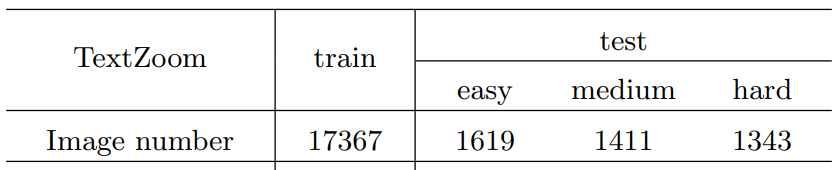

In [4]:
# TODO change for train1 at the end since it's > 10000
data_path = 'data/TextZoom/train2_img/'
lmdb_file = 'data/TextZoom/train2'
N = mdb_to_jpg(data_path, lmdb_file)

Number of samples: 2794


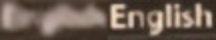

In [5]:
# DISPLAY EXEMPLARY IMAGES
x = 10
imgHR = cv2.imread(data_path+str(x)+'_img_HR.jpg', 1)
imgLR = cv2.imread(data_path+str(x)+'_img_LR.jpg', 1)
show_LR_HR_images(imgLR, imgHR)

In [6]:
# GET HR AND LR images
img_data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)])

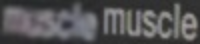

In [7]:
# GET HR AND LR images
data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)])
x = 1234
show_LR_HR_images(img_data[x][0], img_data[x][1])

### Data preprocessing

In [8]:
LR_images = list(map(lambda x: x[0].shape[:-1], img_data))
HR_images = list(map(lambda x: x[1].shape[:-1], img_data))

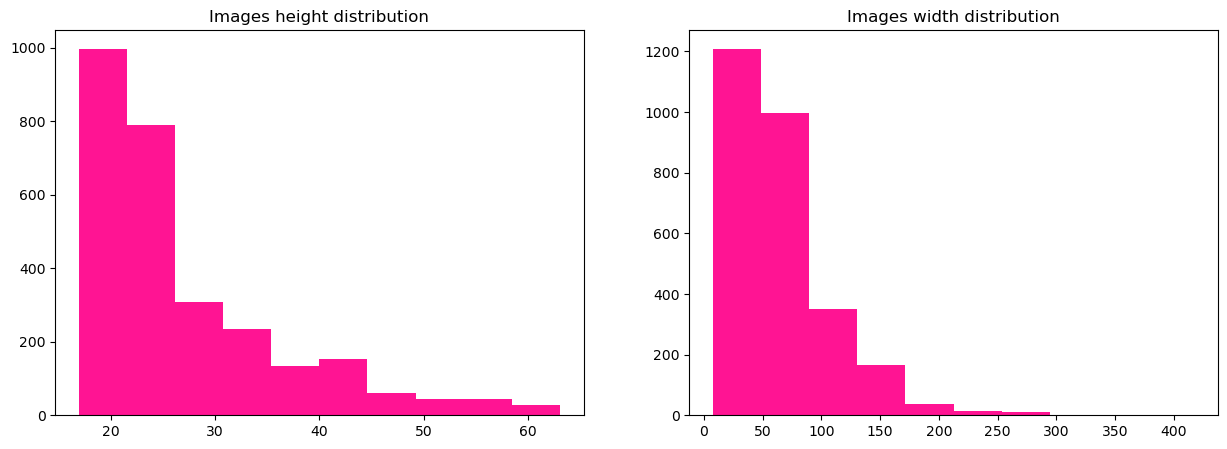

In [9]:
get_height_width_distribution(LR_images)

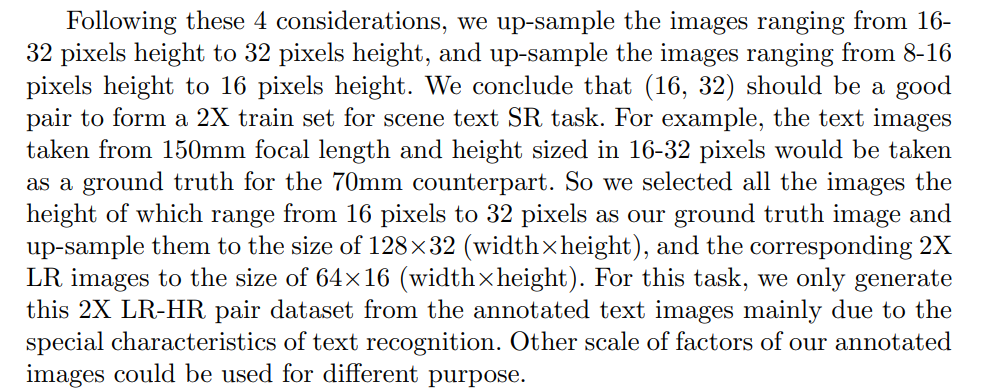<br>
For now I'll just discard the images which height is less than 8 (as they did in paper) and unify the size by padding (but this one should be discussed)

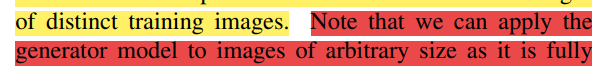<br>
Rozumiem to tak, że obrazek może być dowolnych wymiarów bo skoro są fully convolutional, i.e. `A fully convolution network (FCN) is a neural network that only performs convolution (and subsampling or upsampling) operations. Equivalently, an FCN is a CNN without fully connected layers.`<br>

In [10]:
img_data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)], min_height=8)

In [11]:
class SRDataset(Dataset):
    def __init__(self, images, crop_size=None, normalize=True): 
        self.normalize = normalize
        self.crop_size = crop_size
        self.images = images

    def __len__(self):
        return len(self.images)

    def preprocess_image(self, image):
        if self.crop_size is not None:
            hr_cropped = cv2.resize(image[0], self.crop_size)
            lr_cropped = cv2.resize(image[1], (24, 24))
        # TODO patching?
        if self.normalize:
            lr_norm = lr_cropped / 255
            hr_norm = hr_cropped / 255 # [0, 1]

            return torch.tensor(lr_norm).swapaxes(1,2).swapaxes(0,1), torch.tensor(hr_norm).swapaxes(1,2).swapaxes(0,1)
        return torch.tensor(image[0]).swapaxes(1,2).swapaxes(0,1), torch.tensor(image[1]).swapaxes(1,2).swapaxes(0,1)

    def __getitem__(self, index):        
        image = self.images[index]         
        return self.preprocess_image(image)

In [12]:
img_data = SRDataset(img_data, crop_size=(96,96))

In [13]:
img_data[23][1].shape # same as in model input

torch.Size([3, 96, 96])

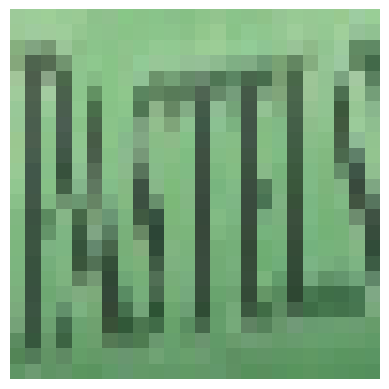

In [14]:
x = 2343
display_img_tensor(img_data[x][0])

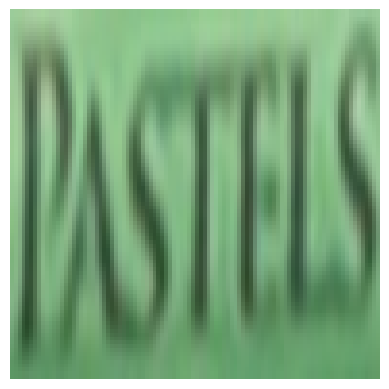

In [15]:
display_img_tensor(img_data[x][1])

In [16]:
train_indices, test_indices = train_test_split(range(N), test_size=0.2)
len(train_indices), len(test_indices)

(2235, 559)

## Models

In [17]:
# https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/2 
cudnn.benchmark = False # cause our input size vary
loss_curve_train = []
loss_curve_test = []

BATCH_SIZE = 1

train_set = torch.utils.data.Subset(img_data, train_indices)
test_set = torch.utils.data.Subset(img_data, test_indices)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [18]:
epochs = 250    # training iterations

vgg19_i = 5  # TODO the index i in the definition for VGG loss; see paper or models.py
vgg19_j = 4  # TODO the index j in the definition for VGG loss; see paper or models.py
beta = 1e-3  # the coefficient to weight the adversarial loss in the perceptual loss
lr = 1e-4  # learning rate

In [19]:
# TODO - put the losses here; maybe EarlyStopping is not necessary at all?
class EarlyStopper:
    def __init__(self, patience, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_accuracy = -np.inf

    def early_stop(self, test_accuracy):
        if test_accuracy > self.max_accuracy:
            self.max_accuracy = test_accuracy
            self.counter = 0
        elif test_accuracy <= (self.max_accuracy + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [20]:
# TODO: possibility to initialize generator networks with pretrained SRResNet/ pre trained discriminator

# Generator
generator = _NetG()
# p.requires_grad in case of a loaded pre-trained model 
optimizer_g = torch.optim.Adam(params=filter(lambda p: p.requires_grad, generator.parameters()), lr=lr)

# Discriminator
discriminator = _NetD()
optimizer_d = torch.optim.Adam(params=filter(lambda p: p.requires_grad, discriminator.parameters()), lr=lr)

# Loss functions
criterion = nn.L1Loss()
content_loss_criterion = nn.MSELoss()
adversarial_loss_criterion = nn.BCEWithLogitsLoss()

# Move to default device
generator = generator.to(device)
discriminator = discriminator.to(device)
content_loss_criterion = content_loss_criterion.to(device)
adversarial_loss_criterion = adversarial_loss_criterion.to(device)

In [21]:
def train_GAN(generator, discriminator, loaders, optimizers, losses, epochs=5, beta=1e-3):

    train_loader, test_loader = loaders
    optimizer_g, optimizer_d = optimizers
    criterion, adversarial_loss_criterion = losses
    # criterion, content_loss_criterion, adversarial_loss_criterion = losses -> content_loss VGG
    generator = generator.float()
    # discriminator = discriminator.float()

    for epoch in range(epochs):
        generator.train()
        discriminator.train()
    
        for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device) 
            print(lr_imgs.shape, hr_imgs.shape)

            # TODO add VGG!

            # GENERATOR
            # generate SR images
            sr_imgs = generator(lr_imgs.float())
            print(sr_imgs.shape)
            # discriminate SR images
            sr_discriminated = discriminator(sr_imgs.float())
            print(sr_discriminated.shape)

            # calculate loss
            # content_loss = content_loss_criterion(sr_imgs_in_vgg_space, hr_imgs_in_vgg_space)
            adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.ones_like(sr_discriminated))
            # perceptual_loss = content_loss + beta * adversarial_loss
            perceptual_loss = beta * adversarial_loss

            optimizer_g.zero_grad()
            perceptual_loss.backward()
            optimizer_g.step()

            # DISCRIMINATOR
            hr_discriminated = discriminator(hr_imgs.float())
            sr_discriminated = discriminator(sr_imgs.detach())

            # calculate loss
            adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.zeros_like(sr_discriminated)) + \
                            adversarial_loss_criterion(hr_discriminated, torch.ones_like(hr_discriminated))
            
            optimizer_d.zero_grad()
            adversarial_loss.backward()
            optimizer_d.step()

        
        generator.eval()
        discriminator.eva;()
        for i, (lr_imgs, hr_imgs) in enumerate(test_loader):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device) 

            sr_imgs = generator(lr_imgs)
            loss = criterion(sr_imgs, hr_imgs)

In [22]:
# dobra jednak trzeba dać ten patching chyba
train_GAN(generator, discriminator, (train_loader, test_loader), 
        (optimizer_g, optimizer_d), (criterion, adversarial_loss_criterion))

torch.Size([1, 3, 24, 24]) torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1])
torch.Size([1, 3, 24, 24]) torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1])
torch.Size([1, 3, 24, 24]) torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1])
torch.Size([1, 3, 24, 24]) torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1])
torch.Size([1, 3, 24, 24]) torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1])
torch.Size([1, 3, 24, 24]) torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1])
torch.Size([1, 3, 24, 24]) torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1])
torch.Size([1, 3, 24, 24]) torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1])
torch.Size([1, 3, 24, 24]) torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1])
torch.Size([1, 3, 24, 24]) torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1])
torch.Size([1, 3, 24, 24]) tor

KeyboardInterrupt: 